<a href="https://colab.research.google.com/github/arnaud-feldmann/projet_distillation_cnam/blob/main/distillation_hors_ligne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install keras_cv image_classifiers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from classification_models.keras import Classifiers
from keras.datasets import cifar100
from keras import Sequential
from keras import Input
from keras.layers import UpSampling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import RandomFlip
from keras.layers import RandomTranslation
from keras.layers import RandomRotation
from keras.layers import RandomBrightness
from keras.layers import RandomContrast
from keras.layers import RandomZoom
from keras.layers import GlobalAveragePooling2D
from keras_cv.layers import RandomShear
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Model
import keras_cv
import re
import os
import datetime

In [14]:
n_epoch = 1000 # Il y a le early stopping
batch_size = 400

In [15]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train = np.float64(X_train)/255
X_test = np.float64(X_test)/255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = 100

In [17]:
modele_enseignant = tf.keras.models.load_model("/content/drive/MyDrive/projet_cnam/modele_745.keras")

In [18]:
y_train_enseignant = modele_enseignant.predict(X_train)

1563/1563 [==============================] - 31s 17ms/step


In [19]:
ResNet18, preprocess_input = Classifiers.get('resnet18')
resnet = ResNet18((224, 224, 3), weights='imagenet', include_top=False)
resnet_output = GlobalAveragePooling2D()(resnet.output)
resnet = Model(inputs=resnet.input, outputs=resnet_output)

resnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 224, 224, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_18 (ZeroPad  (None, 230, 230, 3)          0         ['bn_data[0][0]']             
 ding2D)                                                                                          
                                                                                            

In [40]:
model = Sequential([
    UpSampling2D(size=(7, 7)),
    RandomFlip("horizontal"),
    RandomTranslation(0.2,0.2),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomShear(0.2),
    RandomBrightness(0.2,value_range=(0,1)),
    RandomContrast(0.2),
    resnet,
    Dropout(0.25),
    Dense(256, activation="sigmoid", kernel_regularizer = tf.keras.regularizers.L1(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax", kernel_regularizer = tf.keras.regularizers.L2(0.001) )])

In [41]:
model.compile(optimizer='adam', loss='kl_divergence', metrics=['accuracy'])
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train_enseignant, epochs=n_epoch, batch_size=batch_size, validation_split = 0.1,callbacks = early_stopping_callback)
model.save("/root/modele_enseigne.keras")

Epoch 1/1000
113/113 [==============================] - 40s 265ms/step - loss: 5.3630 - accuracy: 0.5674 - val_loss: 2.6600 - val_accuracy: 0.6406
Epoch 2/1000
113/113 [==============================] - 29s 259ms/step - loss: 2.0633 - accuracy: 0.7009 - val_loss: 1.7448 - val_accuracy: 0.6542
Epoch 3/1000
113/113 [==============================] - 29s 259ms/step - loss: 1.7098 - accuracy: 0.7152 - val_loss: 1.5873 - val_accuracy: 0.6694
Epoch 4/1000
113/113 [==============================] - 29s 259ms/step - loss: 1.6005 - accuracy: 0.7216 - val_loss: 1.5497 - val_accuracy: 0.6704
Epoch 5/1000
113/113 [==============================] - 29s 259ms/step - loss: 1.5250 - accuracy: 0.7345 - val_loss: 1.4691 - val_accuracy: 0.6820
Epoch 6/1000
113/113 [==============================] - 29s 259ms/step - loss: 1.4685 - accuracy: 0.7401 - val_loss: 1.7352 - val_accuracy: 0.6024
Epoch 7/1000
113/113 [==============================] - 29s 259ms/step - loss: 1.4116 - accuracy: 0.7501 - val_loss: 1

In [42]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 3s 8ms/step - loss: 1.6528 - accuracy: 0.6975


[1.6528387069702148, 0.6974999904632568]

In [52]:
ResNet18, preprocess_input = Classifiers.get('resnet18')
resnet = ResNet18((224, 224, 3), weights='imagenet', include_top=False)
resnet_output = GlobalAveragePooling2D()(resnet.output)
resnet = Model(inputs=resnet.input, outputs=resnet_output)
model_temoin = Sequential([
    UpSampling2D(size=(7, 7)),
    RandomFlip("horizontal"),
    RandomTranslation(0.2,0.2),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomShear(0.2),
    RandomBrightness(0.2,value_range=(0,1)),
    RandomContrast(0.2),
    resnet,
    Dropout(0.25),
    Dense(256, activation="sigmoid", kernel_regularizer = tf.keras.regularizers.L1(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax", kernel_regularizer = tf.keras.regularizers.L2(0.001))])

In [53]:
model_temoin.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_temoin = model_temoin.fit(X_train, y_train, epochs=n_epoch, batch_size=batch_size, validation_split = 0.1,callbacks = early_stopping_callback)

Epoch 1/1000
113/113 [==============================] - 40s 266ms/step - loss: 6.6940 - accuracy: 0.1256 - val_loss: 6.1290 - val_accuracy: 0.0060
Epoch 2/1000
113/113 [==============================] - 29s 259ms/step - loss: 3.8506 - accuracy: 0.2502 - val_loss: 5.7719 - val_accuracy: 0.0088
Epoch 3/1000
113/113 [==============================] - 29s 259ms/step - loss: 3.4178 - accuracy: 0.3245 - val_loss: 6.2616 - val_accuracy: 0.0098
Epoch 4/1000
113/113 [==============================] - 29s 259ms/step - loss: 3.1687 - accuracy: 0.3831 - val_loss: 5.5017 - val_accuracy: 0.0452
Epoch 5/1000
113/113 [==============================] - 29s 259ms/step - loss: 2.9707 - accuracy: 0.4344 - val_loss: 5.8856 - val_accuracy: 0.0480
Epoch 6/1000
113/113 [==============================] - 29s 259ms/step - loss: 2.8198 - accuracy: 0.4712 - val_loss: 5.0910 - val_accuracy: 0.1194
Epoch 7/1000
113/113 [==============================] - 29s 259ms/step - loss: 2.6866 - accuracy: 0.5066 - val_loss: 4

In [54]:
model_temoin.evaluate(X_test,y_test)

313/313 [==============================] - 2s 7ms/step - loss: 1.9605 - accuracy: 0.6699


[1.9604902267456055, 0.6699000000953674]

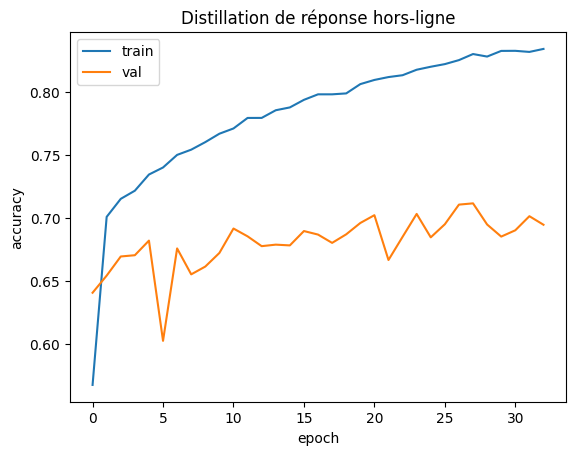

In [57]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'][:])
plt.plot(history.history['val_accuracy'][:])
plt.title('Distillation de réponse hors-ligne')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

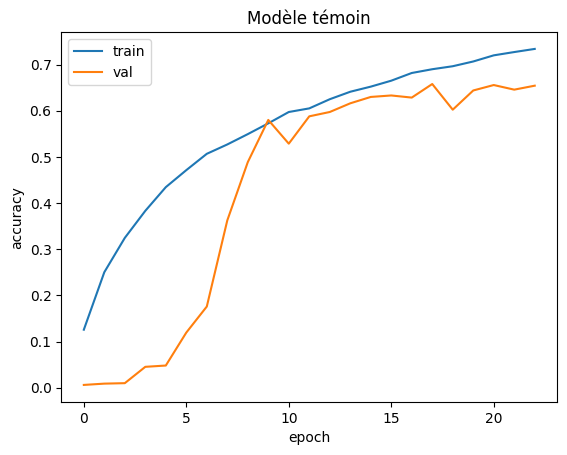

In [59]:
from matplotlib import pyplot as plt
plt.plot(history_temoin.history['accuracy'][:])
plt.plot(history_temoin.history['val_accuracy'][:])
plt.title('Modèle témoin')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()